# Feature Extraction on Nist

In [39]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from sarpy.datasets import load_nist
from scipy import ndimage
from skimage.feature import shape_index
from skimage.measure import label
from skimage.measure import regionprops
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


dataset = load_nist()

In [40]:
def features(bitmap):
    f = []
    
    label_img = label(bitmap)
    props = regionprops(label_img)
    f.append(props[0].area)
#     f.append(props[1].area)
    f.append(props[0].bbox_area)
    f.append(props[0].convex_area)
    f.append(props[0].eccentricity)
    f.append(props[0].equivalent_diameter)
    f.append(props[0].euler_number)
    f.append(props[0].extent)
    f.append(props[0].filled_area)
    f.append(props[0].major_axis_length)
    f.append(props[0].perimeter)
    f.append(props[0].solidity)
    centroid_raw, centroid_col = props[0].centroid
    f.append(centroid_raw)
    f.append(centroid_col)
    
    f.append(np.sum(bitmap))
    f.append(np.mean(bitmap))
    x, y = ndimage.measurements.center_of_mass(bitmap)
    f.append(x)
    f.append(y)
    f.append(ndimage.standard_deviation(bitmap))
    
    return f

In [41]:
def feature_extraction(dataset):
    X = dataset['bitmaps']
    Y = dataset['targets']

    M = []
    for i in range(len(X)):
        feat = features(X[i].data)
#         M.append((feat, Y[i])
        feat.append(Y[i])
        M.append(feat)
    M = np.asarray(M)   
    print(M.shape)
    return M

In [43]:
## database features and labels
# sample 6200 images
# featured = feature_extraction(dataset)
# 
# replace here !!! featured = feature_extraction(dataset)
# sample 400 images minimal example 
mindata = {'bitmaps':dataset['bitmaps'][0:400],'targets':dataset['targets'][0:400]}
featured = feature_extraction(mindata)

(400, 19)


---------------------
      DATASET    
(400, 19)
(400, 18)
(400,)
samples        :  400
total features :  18

>> Classifiers
cross validation, kfolds =  5 

+ Nearest Neighbors
+ Linear SVM
+ RBF SVM
+ Decision Tree
+ Random Forest


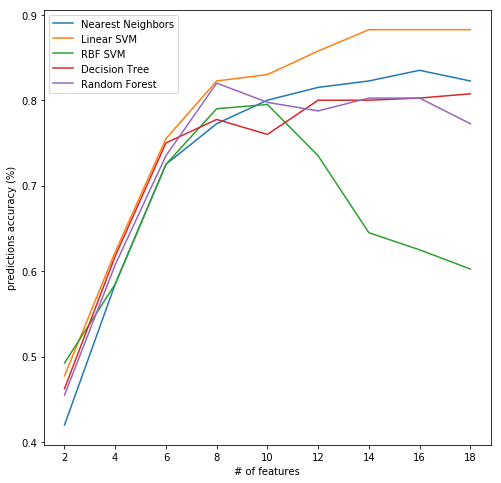

In [45]:
# Classiers names
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Decision Tree", 
         "Random Forest", 
#           "Neural Net", 
#          "AdaBoost",
#           "Naive Bayes", 
#          "QDA",
#          "Gaussian Process",
        ]
# Setting classifiers initial parameters
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1),
#      AdaBoostClassifier()
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
#    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),

]

datasets = [featured]
kfolds   = 5 # number of kfolds

for data in datasets:
    print("---------------------")
    print("      DATASET    ")

    print(data.shape)
    #
    #
    # Load X : features and y : labels
    # modify here !!!
    X = data[:,0:data.shape[1]-1]
    y = data[:,data.shape[1]-1]
    #
    #
    #
    
    print(X.shape)
    print(y.shape)
    # Standardize features
    X = StandardScaler().fit_transform(X)
    
    print("samples        : ",X.shape[0]) # number of samples
    print("total features : ",X.shape[1]) # number of features
       
    
    # Initial Plot parameters  
    plt.figure(figsize=(8,8))
    #colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')
    
    # iterate over classifiers names and configurations
    print("\n>> Classifiers")
    print("cross validation, kfolds = ",kfolds,"\n")
    for name, clf in zip(names, classifiers):
        print("+",name)
        #plot x and y
        x_graph = [0]
        y_graph =[[0,0]]
        
        # increase number of features at each iteration for comparations
        for j in range (0,X.shape[1],2):
            
            ttx = X[:,:j+2]
            #Cross validation 5-folds  (5 classifications)           
            scores = cross_val_score(clf, ttx, y, cv=kfolds)
            
            #add results to plot
            x_graph = np.append(x_graph , (j+2))
            y_graph = np.concatenate((y_graph,[[np.mean(scores),np.std(scores)]]),axis=0)
        
        y_graph = y_graph[1:]
        x_graph = x_graph[1:]
        
        plt.plot(x_graph,y_graph[:,0],label=name)
        plt.legend()
    plt.xlabel('# of features')
    plt.ylabel('predictions accuracy (%)')
    plt.show()
    